In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy import stats
from statsmodels.stats import multicomp
from statsmodels.stats.proportion import proportions_ztest

from scipy.stats import pearsonr


In [2]:
# Importing the data
df = pd.read_csv("/Users/charlescai/Desktop/BrainStation/IndustrySprintAssets/complaints.csv")

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11572834 entries, 0 to 11572833
Data columns (total 18 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   Date received                 datetime64[ns]
 1   Product                       object        
 2   Sub-product                   object        
 3   Issue                         object        
 4   Sub-issue                     object        
 5   Consumer complaint narrative  object        
 6   Company public response       object        
 7   Company                       object        
 8   State                         object        
 9   ZIP code                      object        
 10  Tags                          object        
 11  Consumer consent provided?    object        
 12  Submitted via                 object        
 13  Date sent to company          datetime64[ns]
 14  Company response to consumer  object        
 15  Timely response?              

In [6]:
#Unique States in the original df
sorted(df['State'].dropna().astype(str).unique())

['AA',
 'AE',
 'AK',
 'AL',
 'AP',
 'AR',
 'AS',
 'AZ',
 'CA',
 'CO',
 'CT',
 'DC',
 'DE',
 'FL',
 'FM',
 'GA',
 'GU',
 'HI',
 'IA',
 'ID',
 'IL',
 'IN',
 'KS',
 'KY',
 'LA',
 'MA',
 'MD',
 'ME',
 'MH',
 'MI',
 'MN',
 'MO',
 'MP',
 'MS',
 'MT',
 'NC',
 'ND',
 'NE',
 'NH',
 'NJ',
 'NM',
 'NV',
 'NY',
 'OH',
 'OK',
 'OR',
 'PA',
 'PR',
 'PW',
 'RI',
 'SC',
 'SD',
 'TN',
 'TX',
 'UNITED STATES MINOR OUTLYING ISLANDS',
 'UT',
 'VA',
 'VI',
 'VT',
 'WA',
 'WI',
 'WV',
 'WY']

In [7]:
#Assigning datetime data type to these two columns in case if needed down the analysis. 
df['Date received'] = pd.to_datetime(df['Date received'])
df['Date sent to company'] = pd.to_datetime(df['Date sent to company'])

In [8]:
#Exploring NaNs
df.isna().sum()

Date received                          0
Product                                0
Sub-product                       235295
Issue                                  6
Sub-issue                         862722
Consumer complaint narrative     8146926
Company public response          5729028
Company                                0
State                              56900
ZIP code                           30229
Tags                            10900062
Consumer consent provided?       1927560
Submitted via                          0
Date sent to company                   0
Company response to consumer          20
Timely response?                       0
Consumer disputed?              10804550
Complaint ID                           0
dtype: int64

In [9]:
#Understanding product proportions among all complaints
df['Product'].value_counts().sort_values(ascending=False)

Product
Credit reporting or other personal consumer reports                             6602079
Credit reporting, credit repair services, or other personal consumer reports    2163850
Debt collection                                                                  898024
Mortgage                                                                         430367
Checking or savings account                                                      315826
Credit card                                                                      258672
Credit card or prepaid card                                                      206368
Money transfer, virtual currency, or money service                               156689
Credit reporting                                                                 140429
Student loan                                                                     115209
Bank account or service                                                           86204
Vehicle loan or lease   

In [5]:
#Examining each company's proportion among all complaints.
(df['Company'].value_counts() / len(df) * 100).head(30)

Company
EQUIFAX, INC.                             25.464705
TRANSUNION INTERMEDIATE HOLDINGS, INC.    24.851570
Experian Information Solutions Inc.       22.912132
BANK OF AMERICA, NATIONAL ASSOCIATION      1.421182
WELLS FARGO & COMPANY                      1.326313
JPMORGAN CHASE & CO.                       1.305203
CAPITAL ONE FINANCIAL CORPORATION          1.214275
CITIBANK, N.A.                             1.032193
SYNCHRONY FINANCIAL                        0.590054
Block, Inc.                                0.488221
AMERICAN EXPRESS COMPANY                   0.423120
Resurgent Capital Services L.P.            0.422031
Portfolio Recovery Associates, LLC         0.392877
ENCORE CAPITAL GROUP INC.                  0.390769
U.S. BANCORP                               0.375310
Navient Solutions, LLC.                    0.372787
DISCOVER BANK                              0.355177
NAVY FEDERAL CREDIT UNION                  0.342682
Bread Financial Holdings, Inc.             0.333531
Ocwe

In [10]:
#Filtering and counting entries associated with Equifax, Transunion, Experian, 
df[df['Company'].isin([
    'EQUIFAX, INC.',
    'TRANSUNION INTERMEDIATE HOLDINGS, INC.',
    'Experian Information Solutions Inc.'
])]['Company'].value_counts()

Company
EQUIFAX, INC.                             2946988
TRANSUNION INTERMEDIATE HOLDINGS, INC.    2876031
Experian Information Solutions Inc.       2651583
Name: count, dtype: int64

In [11]:
#getting rid of credit bureaus by using isin to first locate the records, then combining ~ to filp them to False
df2 = df[~df['Company'].isin(['EQUIFAX, INC.', 'TRANSUNION INTERMEDIATE HOLDINGS, INC.', 'Experian Information Solutions Inc.'])]

In [12]:
#checking entry count after the first trimming
df2.describe()

,Date received,Date sent to company,Complaint ID
count,3098232,3098232,3.098232e+06
mean,2021-02-26 15:18:07.560130560,2021-02-28 20:58:07.560129280,6.397372e+06
min,2011-12-01 00:00:00,2011-12-01 00:00:00,1.000000e+00
25%,2018-02-27 00:00:00,2018-02-28 00:00:00,2.827637e+06
50%,2022-03-04 00:00:00,2022-03-07 00:00:00,5.287810e+06
75%,2024-08-19 00:00:00,2024-08-20 00:00:00,9.854131e+06
max,2025-10-21 00:00:00,2025-10-21 00:00:00,1.673837e+07
std,NaN,NaN,4.457223e+06


### At this point, we had talked to Solomon about what products/areas that Wealthsimple would be interested in. Based on that chat, we then decided to remove products that Wealthsimple do not offer/will not likely offer in near future.

In [13]:
df2['Product'].value_counts().sort_values(ascending=False)

Product
Debt collection                                                                 758639
Mortgage                                                                        429866
Credit reporting or other personal consumer reports                             349045
Checking or savings account                                                     315070
Credit reporting, credit repair services, or other personal consumer reports    274244
Credit card                                                                     211072
Credit card or prepaid card                                                     200421
Money transfer, virtual currency, or money service                              156475
Student loan                                                                    114497
Bank account or service                                                          86155
Vehicle loan or lease                                                            78455
Consumer Loan                      

In [14]:
#getting rid of irrelevant products, same technique used for the first filtering 
df3 = df2[~df2['Product'].isin(['Debt collection', 'Payday loan, title loan, or personal loan', 'Payday loan, title loan, personal loan, or advance loan','Payday loan'])]

In [15]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2282895 entries, 17 to 11572833
Data columns (total 18 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   Date received                 datetime64[ns]
 1   Product                       object        
 2   Sub-product                   object        
 3   Issue                         object        
 4   Sub-issue                     object        
 5   Consumer complaint narrative  object        
 6   Company public response       object        
 7   Company                       object        
 8   State                         object        
 9   ZIP code                      object        
 10  Tags                          object        
 11  Consumer consent provided?    object        
 12  Submitted via                 object        
 13  Date sent to company          datetime64[ns]
 14  Company response to consumer  object        
 15  Timely response?              objec

### This dataset contains a lot of years of information. Since the financial scene is always changing, we decided to focus on post covid years only (2020-2025)

In [16]:
# Define the date range
start_date = '2020-01-01'
end_date = '2025-12-31'

# Filter the DataFrame
filtered_date_df = df3[(df3['Date received'] >= start_date) & (df3['Date received'] <= end_date)]

In [17]:
filtered_date_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1494430 entries, 17 to 11572833
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   Date received                 1494430 non-null  datetime64[ns]
 1   Product                       1494430 non-null  object        
 2   Sub-product                   1494368 non-null  object        
 3   Issue                         1494424 non-null  object        
 4   Sub-issue                     1245615 non-null  object        
 5   Consumer complaint narrative  733293 non-null   object        
 6   Company public response       533262 non-null   object        
 7   Company                       1494430 non-null  object        
 8   State                         1477169 non-null  object        
 9   ZIP code                      1487571 non-null  object        
 10  Tags                          210752 non-null   object        
 11  C

### Our check in with Solomon gave us the direction of how to differentiate them from traditional banks. We decided to look at how complaints are associated with companies, so we could gain a starting point for that direction.

In [18]:
filtered_date_df['Company'].value_counts().mean()

304.86128110975113

In [19]:
company_counts = (
    filtered_date_df['Company']
    .value_counts()
    .reset_index()
)

company_counts.columns = ['Company', 'Count']
company_counts.head()


,Company,Count
0,CAPITAL ONE FINANCIAL CORPORATION,90972
1,JPMORGAN CHASE & CO.,81680
2,WELLS FARGO & COMPANY,73577
3,"BANK OF AMERICA, NATIONAL ASSOCIATION",73307
4,"CITIBANK, N.A.",60336


### Complaints are mostly associated with the major banks/financial institutions.

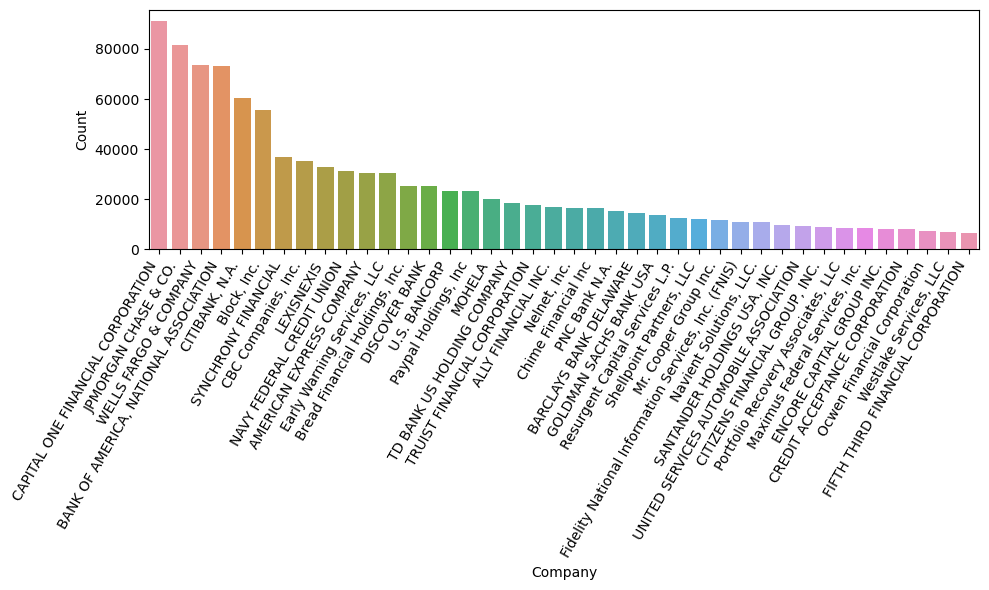

In [20]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=company_counts.head(40),
    x='Company',
    y='Count'
)

plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

In [21]:
company_counts.shape

(4902, 2)

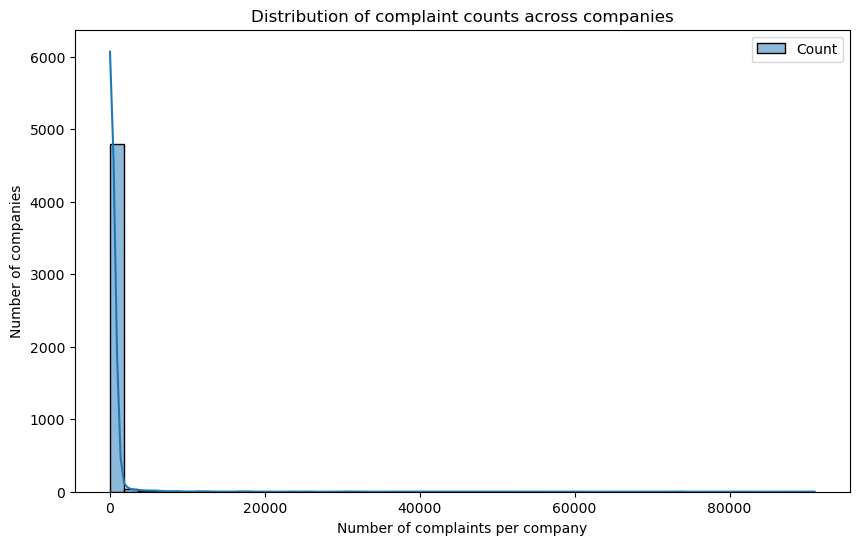

In [22]:
# This histoplot was used to examine 
plt.figure(figsize=(10,6))
sns.histplot(company_counts, bins=50, kde=True)
plt.xlabel("Number of complaints per company")
plt.ylabel("Number of companies")
plt.title("Distribution of complaint counts across companies")
plt.show()

In [23]:
company_counts[company_counts['Count'] <= 5].shape[0]

2649

We took a lookat the percentage of each company in this df. At this point, we also had done some external research and decided to futher reduce our data to include banks/finanicial institutions that are comparable in asset to the big five in Canada.

In [24]:
(filtered_date_df['Company'].value_counts() / len(filtered_date_df) * 100).head(60)

Company
CAPITAL ONE FINANCIAL CORPORATION                      6.087405
JPMORGAN CHASE & CO.                                   5.465629
WELLS FARGO & COMPANY                                  4.923416
BANK OF AMERICA, NATIONAL ASSOCIATION                  4.905349
CITIBANK, N.A.                                         4.037392
Block, Inc.                                            3.728110
SYNCHRONY FINANCIAL                                    2.465422
CBC Companies, Inc.                                    2.365651
LEXISNEXIS                                             2.208534
NAVY FEDERAL CREDIT UNION                              2.092035
AMERICAN EXPRESS COMPANY                               2.047269
Early Warning Services, LLC                            2.032614
Bread Financial Holdings, Inc.                         1.704797
DISCOVER BANK                                          1.695964
U.S. BANCORP                                           1.567889
Paypal Holdings, Inc            

In [25]:
# These are the keywords for top banks in the US that we did not see in the list above.

keywords = [
    "SCHWAB",
    "NEW YORK MELLON",
    "BMO",
    "HSBC",
    "NORTHERN TRUST",
    "REGIONS",
    "UBS",
    "ROBIN"
]

#string match to search for the names of the missing top banks in this dataset. 

for k in keywords:
    print(f"\n--- Results for {k} ---")
    display(filtered_date_df[filtered_date_df['Company'].str.contains(k, case=False, na=False)][['Company']].drop_duplicates())



--- Results for SCHWAB ---


,Company
15816,"CHARLES SCHWAB CORPORATION, THE"



--- Results for NEW YORK MELLON ---


,Company
11060,"BANK OF NEW YORK MELLON CORPORATION, THE"



--- Results for BMO ---


,Company
17398,"BMO Bank, N.A."



--- Results for HSBC ---


,Company
5475,HSBC NORTH AMERICA HOLDINGS INC.



--- Results for NORTHERN TRUST ---


,Company
406803,"Northern Trust Company, The"



--- Results for REGIONS ---


,Company
20245,REGIONS FINANCIAL CORPORATION



--- Results for UBS ---


,Company
284671,UBS BANK USA



--- Results for ROBIN ---


,Company
4418,ROBINHOOD MARKETS INC.
321209,Robinson & Hoover
3054916,"Robinson, Reagan and Young PLLC"


In [26]:
#Defining what banks should be included in the next df.
major_banks_final = [
    # --- From Top 60 (legal entities as they appear) ---
    "CAPITAL ONE FINANCIAL CORPORATION",
    "JPMORGAN CHASE & CO.",
    "WELLS FARGO & COMPANY",
    "BANK OF AMERICA, NATIONAL ASSOCIATION",
    "CITIBANK, N.A.",
    "SYNCHRONY FINANCIAL",
    "AMERICAN EXPRESS COMPANY",
    "DISCOVER BANK",
    "U.S. BANCORP",
    "TRUIST FINANCIAL CORPORATION",
    "ALLY FINANCIAL INC.",
    "CITIZENS FINANCIAL GROUP, INC.",
    "FIFTH THIRD FINANCIAL CORPORATION",
    "HUNTINGTON NATIONAL BANK, THE",
    "GOLDMAN SACHS BANK USA",
    "PNC Bank N.A.",
    "TD BANK US HOLDING COMPANY",
    "SANTANDER HOLDINGS USA, INC.",
    "UNITED SERVICES AUTOMOBILE ASSOCIATION",
    
    # --- Additional 7 banks found under different names ---
    "HSBC NORTH AMERICA HOLDINGS INC.",
    "CHARLES SCHWAB CORPORATION, THE",
    "BANK OF NEW YORK MELLON CORPORATION, THE",
    "BMO Bank, N.A.",
    "Northern Trust Company, The",
    "REGIONS FINANCIAL CORPORATION",
    "UBS BANK USA",
]

In [27]:
bank_df = filtered_date_df[filtered_date_df['Company'].isin(major_banks_final)]


In [75]:
bank_df['Product'].value_counts().sort_values(ascending=False)

Product
Checking or savings account                                                     181935
Credit card or prepaid card                                                      99737
Credit card                                                                      94211
Credit reporting or other personal consumer reports                              92648
Credit reporting, credit repair services, or other personal consumer reports     70902
Mortgage                                                                         32428
Money transfer, virtual currency, or money service                               28184
Vehicle loan or lease                                                            21757
Prepaid card                                                                      5982
Student loan                                                                       994
Debt or credit management                                                          573
Name: count, dtype: int64

In [38]:
# Student loan and Vehicle loan/lease are not offered by Wealthsimple, so we dropped them as well.
cleaned_bank = bank_df[~bank_df['Product'].isin(['Student loan', 'Vehicle loan or lease'])].copy()

In [39]:
cleaned_bank.info()

<class 'pandas.core.frame.DataFrame'>
Index: 606600 entries, 17 to 11572833
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   Date received                 606600 non-null  datetime64[ns]
 1   Product                       606600 non-null  object        
 2   Sub-product                   606564 non-null  object        
 3   Issue                         606597 non-null  object        
 4   Sub-issue                     552513 non-null  object        
 5   Consumer complaint narrative  296818 non-null  object        
 6   Company public response       299400 non-null  object        
 7   Company                       606600 non-null  object        
 8   State                         599725 non-null  object        
 9   ZIP code                      603233 non-null  object        
 10  Tags                          94150 non-null   object        
 11  Consumer consen

## Deposit Hold Complaints Analyses
### To understand complaint narratives, a basic NLP process was introduced to investigate the most frequently seen key words, which then was used as a support for deposit hold recommendation.

In [86]:
#Extracting rows that contain consumer complaint narratives

narrative = cleaned_bank[
    cleaned_bank['Consumer complaint narrative'].notna()
]

narrative.info()

<class 'pandas.core.frame.DataFrame'>
Index: 296818 entries, 713 to 11572833
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   Date received                 296818 non-null  datetime64[ns]
 1   Product                       296818 non-null  object        
 2   Sub-product                   296804 non-null  object        
 3   Issue                         296818 non-null  object        
 4   Sub-issue                     268388 non-null  object        
 5   Consumer complaint narrative  296818 non-null  object        
 6   Company public response       149963 non-null  object        
 7   Company                       296818 non-null  object        
 8   State                         294994 non-null  object        
 9   ZIP code                      296818 non-null  object        
 10  Tags                          55206 non-null   object        
 11  Consumer conse

In [73]:
# Define keywords associated with deposit hold.
keywords = [
    "deposit hold", "funds on hold", "held", "hold", 
    "pending deposit", "delayed", "not available", 
    "available", "release", "cleared", "clearing"
]

#joining an OR condition
pattern = "|".join(keywords)

#creating a data frame that contain narratives that contain the previously defined keywords
deposit_narratives = cleaned_bank[
    cleaned_bank["Consumer complaint narrative"]
        .str.contains(pattern, case=False, na=False)
]


In [74]:
from sklearn.feature_extraction.text import CountVectorizer

#setting up the vectorizer to removes extremely common words that appear in more than 80% of documents.
vectorizer = CountVectorizer(
    #stop_words defined so it will skip words like and in like
    stop_words='english',
    max_df=0.8,
    #min_df set to 5 so that keeps only words that appear in at least 5 narratives
    min_df=5
)
X = vectorizer.fit_transform(deposit_narratives["Consumer complaint narrative"])
#outputting the common words found and pairing them with each word's frequency. 
freqs = zip(vectorizer.get_feature_names_out(), X.sum(axis=0).tolist()[0])
#sort everything by the second thing in each tupple (frequency), only look at the top 30
sorted(freqs, key=lambda x: -x[1])[:30]


[('xx', 345303),
 ('account', 234808),
 ('bank', 151805),
 ('00', 121756),
 ('credit', 119567),
 ('card', 100130),
 ('told', 70398),
 ('check', 65836),
 ('funds', 64505),
 ('money', 62877),
 ('called', 57248),
 ('information', 56689),
 ('payment', 55548),
 ('chase', 55371),
 ('did', 54535),
 ('received', 54053),
 ('time', 53152),
 ('said', 46776),
 ('fraud', 42287),
 ('days', 40088),
 ('number', 39904),
 ('phone', 38557),
 ('hold', 38055),
 ('wells', 36695),
 ('consumer', 36126),
 ('fargo', 35441),
 ('customer', 35164),
 ('balance', 33828),
 ('sent', 33607),
 ('asked', 31606)]

## Customer Service Related Complaint Narratives Analyses

##### Part 1: Data cleaning


In [77]:
cleaned_bank_df = cleaned_bank

In [78]:
# Verify the data.
cleaned_bank_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 606600 entries, 17 to 11572833
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   Date received                 606600 non-null  datetime64[ns]
 1   Product                       606600 non-null  object        
 2   Sub-product                   606564 non-null  object        
 3   Issue                         606597 non-null  object        
 4   Sub-issue                     552513 non-null  object        
 5   Consumer complaint narrative  296818 non-null  object        
 6   Company public response       299400 non-null  object        
 7   Company                       606600 non-null  object        
 8   State                         599725 non-null  object        
 9   ZIP code                      603233 non-null  object        
 10  Tags                          94150 non-null   object        
 11  Consumer consen

In [79]:
# Filter out the rows that have a null value in the "Customer complaint narrative"
cleaned_bank_df2 = cleaned_bank_df.dropna(subset=["Consumer complaint narrative"])

In [80]:
# Examine the first few rows of the data.
cleaned_bank_df2.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,Year
713,2025-08-15,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,"On XX/XX/scrub>, 2025 I received a text saying...",NaN,CAPITAL ONE FINANCIAL CORPORATION,IN,463XX,NaN,Consent provided,Web,2025-08-15,Closed with non-monetary relief,Yes,NaN,15305109,2025
831,2025-09-19,Credit reporting or other personal consumer re...,Credit reporting,Problem with a company's investigation into an...,Their investigation did not fix an error on yo...,Consumer Financial Protection Bureau ( CFPB XX...,Company has responded to the consumer and the ...,TRUIST FINANCIAL CORPORATION,GA,XXXXX,Servicemember,Consent provided,Web,2025-09-19,Closed with explanation,Yes,NaN,16054100,2025
1033,2020-03-26,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account information incorrect,I have filed a dispute in regards to the incor...,NaN,JPMORGAN CHASE & CO.,PA,19150,NaN,Consent provided,Web,2020-03-26,Closed with explanation,Yes,NaN,3581699,2020
1745,2025-09-28,Credit card,Store credit card,Getting a credit card,Card opened without my consent or knowledge,Someone tried opening a Best BuXXXX XXXXXXXX X...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",CA,91423,NaN,Consent provided,Web,2025-09-28,Closed with explanation,Yes,NaN,16225666,2025
2023,2025-07-29,"Money transfer, virtual currency, or money ser...",Domestic (US) money transfer,Fraud or scam,NaN,Case Overview Between XX/XX/XXXXXXXX and XX/X...,NaN,PNC Bank N.A.,PA,15317,Older American,Consent provided,Web,2025-07-29,Closed with explanation,Yes,NaN,14947825,2025


In [82]:
# Verify the information.
cleaned_bank_df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 296818 entries, 713 to 11572833
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   Date received                 296818 non-null  datetime64[ns]
 1   Product                       296818 non-null  object        
 2   Sub-product                   296804 non-null  object        
 3   Issue                         296818 non-null  object        
 4   Sub-issue                     268388 non-null  object        
 5   Consumer complaint narrative  296818 non-null  object        
 6   Company public response       149963 non-null  object        
 7   Company                       296818 non-null  object        
 8   State                         294994 non-null  object        
 9   ZIP code                      296818 non-null  object        
 10  Tags                          55206 non-null   object        
 11  Consumer conse

In [81]:
# Count the values for each product
cleaned_bank_df2["Product"].value_counts()

Product
Checking or savings account                                                     92002
Credit card or prepaid card                                                     52920
Credit card                                                                     49698
Credit reporting or other personal consumer reports                             34316
Credit reporting, credit repair services, or other personal consumer reports    33037
Money transfer, virtual currency, or money service                              16078
Mortgage                                                                        15008
Prepaid card                                                                     3428
Debt or credit management                                                         331
Name: count, dtype: int64

##### Part 2: String-matching specific key words associated with customer service
###### Task: Of 296818 complaint narratives, determine how many contain the phrases "customer service", "support", or "help".
###### The union of the three phrases A, B, C = A + B + C - AB - AC - BC + A+B+C (DeMorgan's Law)

###### 2.1: Let A be customer service

In [83]:
# String match search for "customer service" in "Consumer complaint narrative" column.
customer_service_matches_df = cleaned_bank_df2[cleaned_bank_df2["Consumer complaint narrative"].str.contains("customer service", case=False, na=False, regex=True)]

In [84]:
# Verify the data.
customer_service_matches_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31057 entries, 3922 to 11572663
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Date received                 31057 non-null  datetime64[ns]
 1   Product                       31057 non-null  object        
 2   Sub-product                   31057 non-null  object        
 3   Issue                         31057 non-null  object        
 4   Sub-issue                     28462 non-null  object        
 5   Consumer complaint narrative  31057 non-null  object        
 6   Company public response       16168 non-null  object        
 7   Company                       31057 non-null  object        
 8   State                         30784 non-null  object        
 9   ZIP code                      31057 non-null  object        
 10  Tags                          5790 non-null   object        
 11  Consumer consent provided? 

###### The term "Customer service" appeared in 31,077 records.

###### 2.2: Let B be complaints with the word "help"

In [85]:
# String match search for "customer service" in "help" column.
help_matches_df = cleaned_bank_df2[cleaned_bank_df2["Consumer complaint narrative"].str.contains("help", case=False, na=False, regex=True)]

In [86]:
# Verify the data.
help_matches_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49277 entries, 3170 to 11569343
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Date received                 49277 non-null  datetime64[ns]
 1   Product                       49277 non-null  object        
 2   Sub-product                   49273 non-null  object        
 3   Issue                         49277 non-null  object        
 4   Sub-issue                     42146 non-null  object        
 5   Consumer complaint narrative  49277 non-null  object        
 6   Company public response       26925 non-null  object        
 7   Company                       49277 non-null  object        
 8   State                         48790 non-null  object        
 9   ZIP code                      49277 non-null  object        
 10  Tags                          10196 non-null  object        
 11  Consumer consent provided? 

###### There were 49,277 records with the string segment "help".


###### 2.3: Let AB be the complaints with both "customer service" AND help".

In [88]:
# String match search for "customer service" AND "help" in "Consumer complaint narrative" column.
cs_help_matches_df = customer_service_matches_df[customer_service_matches_df["Consumer complaint narrative"].str.contains("help", case=False, na=False, regex=True)]

In [89]:
# Verify the data.
cs_help_matches_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8920 entries, 6801 to 11566246
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Date received                 8920 non-null   datetime64[ns]
 1   Product                       8920 non-null   object        
 2   Sub-product                   8920 non-null   object        
 3   Issue                         8920 non-null   object        
 4   Sub-issue                     7966 non-null   object        
 5   Consumer complaint narrative  8920 non-null   object        
 6   Company public response       4691 non-null   object        
 7   Company                       8920 non-null   object        
 8   State                         8840 non-null   object        
 9   ZIP code                      8920 non-null   object        
 10  Tags                          1662 non-null   object        
 11  Consumer consent provided?  

###### There were 8,920 records with both string segments "Customer service" AND "help".

###### 2.4: Let C be the complaints with the string segment "support".

In [90]:
# String match search for "support" in "Consumer complaint narrative" column.
support_matches_df = cleaned_bank_df2[cleaned_bank_df2["Consumer complaint narrative"].str.contains("support", case=False, na=False, regex=True)]

In [91]:
# Verify the data.
support_matches_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17517 entries, 831 to 11568731
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Date received                 17517 non-null  datetime64[ns]
 1   Product                       17517 non-null  object        
 2   Sub-product                   17517 non-null  object        
 3   Issue                         17517 non-null  object        
 4   Sub-issue                     15971 non-null  object        
 5   Consumer complaint narrative  17517 non-null  object        
 6   Company public response       8243 non-null   object        
 7   Company                       17517 non-null  object        
 8   State                         17346 non-null  object        
 9   ZIP code                      17517 non-null  object        
 10  Tags                          2902 non-null   object        
 11  Consumer consent provided?  

###### There were 17,517 records with the string segment "support".

###### 2.5: Let AC be the complaints with both "customer service" AND "support".

In [92]:
# String match search for "customer service" AND "support" in "Consumer complaint narrative" column.
cs_support_matches_df = customer_service_matches_df[customer_service_matches_df["Consumer complaint narrative"].str.contains("support", case=False, na=False, regex=True)]

In [93]:
# Verify the code.
cs_support_matches_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2964 entries, 5903 to 11558826
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Date received                 2964 non-null   datetime64[ns]
 1   Product                       2964 non-null   object        
 2   Sub-product                   2964 non-null   object        
 3   Issue                         2964 non-null   object        
 4   Sub-issue                     2726 non-null   object        
 5   Consumer complaint narrative  2964 non-null   object        
 6   Company public response       1427 non-null   object        
 7   Company                       2964 non-null   object        
 8   State                         2931 non-null   object        
 9   ZIP code                      2964 non-null   object        
 10  Tags                          506 non-null    object        
 11  Consumer consent provided?  

###### There were 2,964 entries with both "Customer service" AND "support".

###### 2.6: let BC be the complaints with both "help" and "support"

In [94]:
# String match search for "customer service" AND "support" in "Consumer complaint narrative" column.
help_support_matches_df = help_matches_df[help_matches_df["Consumer complaint narrative"].str.contains("support", case=False, na=False, regex=True)]

In [95]:
# Verify the data.
help_support_matches_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4386 entries, 11716 to 11566602
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Date received                 4386 non-null   datetime64[ns]
 1   Product                       4386 non-null   object        
 2   Sub-product                   4386 non-null   object        
 3   Issue                         4386 non-null   object        
 4   Sub-issue                     3795 non-null   object        
 5   Consumer complaint narrative  4386 non-null   object        
 6   Company public response       2213 non-null   object        
 7   Company                       4386 non-null   object        
 8   State                         4324 non-null   object        
 9   ZIP code                      4386 non-null   object        
 10  Tags                          777 non-null    object        
 11  Consumer consent provided? 

In [96]:
# String match search for "customer service", "help", AND "support" in "Consumer complaint narrative" column.
cs_help_support_match_df = cs_help_matches_df[cs_help_matches_df["Consumer complaint narrative"].str.contains("support", case=False, na=False, regex=True)]

In [97]:
# Verify the data.
cs_help_support_match_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1060 entries, 29206 to 11558826
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Date received                 1060 non-null   datetime64[ns]
 1   Product                       1060 non-null   object        
 2   Sub-product                   1060 non-null   object        
 3   Issue                         1060 non-null   object        
 4   Sub-issue                     944 non-null    object        
 5   Consumer complaint narrative  1060 non-null   object        
 6   Company public response       522 non-null    object        
 7   Company                       1060 non-null   object        
 8   State                         1048 non-null   object        
 9   ZIP code                      1060 non-null   object        
 10  Tags                          174 non-null    object        
 11  Consumer consent provided? 

###### There were 1,060 records with all the strings "Customer service", "help", and "support".
##### Count: 31,057 + 49,277 + 17,517 - 8,920 - 2,964 - 4,386 + 1,060 = 82,641
##### 82,641 of 296,818 (27.8%) of complaint narratives have keywords associated with customer service, help, or support.
#####  Over one quarter of complaint narratives contain at least one of "customer service", "help", or "support".

###### 2.8: Plotting the string match findings.

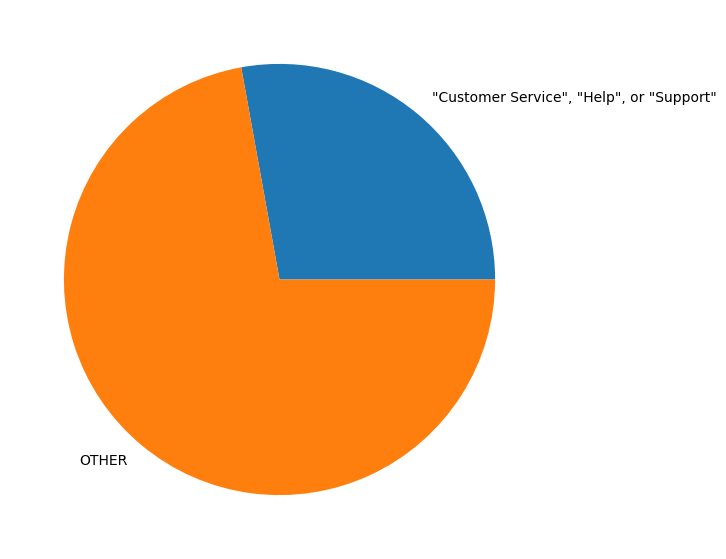

In [98]:
# Creating dataset
keywords = ['"Customer Service", "Help", or "Support"', 'OTHER']

data = [82641, 214177]

# Creating plot
fig = plt.figure(figsize=(10, 7))
plt.pie(data, labels=keywords)

# show plot
plt.show()

###### Part 3: Proportion of specific key words in complaint narratives by Product.

In [99]:
# Grouping the data by product.
product_df = cleaned_bank_df2.groupby("Product").size()
# Sorting the data (descending).
product_sorted_df = product_df.sort_values(ascending=False)
# Presenting the data.
product_sorted_df

Product
Checking or savings account                                                     92002
Credit card or prepaid card                                                     52920
Credit card                                                                     49698
Credit reporting or other personal consumer reports                             34316
Credit reporting, credit repair services, or other personal consumer reports    33037
Money transfer, virtual currency, or money service                              16078
Mortgage                                                                        15008
Prepaid card                                                                     3428
Debt or credit management                                                         331
dtype: int64

###### 3.1: "Customer service" found in complaint narratives by Product.

In [100]:
# Grouping the "Customer service" string matches by product.
cs_product_df = customer_service_matches_df.groupby("Product").size()
# Sorting the data (descending)
cs_product_sorted_df = cs_product_df.sort_values(ascending=False)
# Presenting the data.
cs_product_sorted_df

Product
Checking or savings account                                                     11615
Credit card or prepaid card                                                      7508
Credit card                                                                      6814
Money transfer, virtual currency, or money service                               1570
Mortgage                                                                         1190
Credit reporting, credit repair services, or other personal consumer reports      855
Credit reporting or other personal consumer reports                               803
Prepaid card                                                                      686
Debt or credit management                                                          16
dtype: int64

In [101]:
# Determining the ratio of records with "Customer service" string to total records, by Product
product_by_cs_proportion_df = cs_product_df/product_df
# Sorting the data (descending)
sorted_product_by_cs_proportion_df = product_by_cs_proportion_df.sort_values(ascending=False)
# Presenting the data.
sorted_product_by_cs_proportion_df

Product
Prepaid card                                                                    0.200117
Credit card or prepaid card                                                     0.141875
Credit card                                                                     0.137108
Checking or savings account                                                     0.126247
Money transfer, virtual currency, or money service                              0.097649
Mortgage                                                                        0.079291
Debt or credit management                                                       0.048338
Credit reporting, credit repair services, or other personal consumer reports    0.025880
Credit reporting or other personal consumer reports                             0.023400
dtype: float64

###### 3.2: "Help" found in complaint narratives by Product.

In [102]:
# Grouping the "help" string matches by product.
help_product_df = help_matches_df.groupby("Product").size()
# Sorting the data (descending)
help_product_sorted_df = help_product_df.sort_values(ascending=False)
# Presenting the data.
help_product_sorted_df

Product
Checking or savings account                                                     18682
Credit card or prepaid card                                                      9617
Credit card                                                                      7497
Money transfer, virtual currency, or money service                               4235
Mortgage                                                                         3398
Credit reporting, credit repair services, or other personal consumer reports     2998
Credit reporting or other personal consumer reports                              2093
Prepaid card                                                                      704
Debt or credit management                                                          53
dtype: int64

In [103]:
# Determining the ratio of records with "help" string to total records, by Product
product_by_help_proportion_df = help_product_df/product_df
# Sorting the data (descending)
product_by_help_proportion_df.sort_values(ascending=False)

Product
Money transfer, virtual currency, or money service                              0.263403
Mortgage                                                                        0.226413
Prepaid card                                                                    0.205368
Checking or savings account                                                     0.203061
Credit card or prepaid card                                                     0.181727
Debt or credit management                                                       0.160121
Credit card                                                                     0.150851
Credit reporting, credit repair services, or other personal consumer reports    0.090747
Credit reporting or other personal consumer reports                             0.060992
dtype: float64

###### 3.3: "Support" found in complaint narratives by Product.

In [104]:
# Grouping the "support" string matches by product.
support_product_df = support_matches_df.groupby("Product").size()

In [105]:
# Sorting the data (descending)
support_product_sorted_df = support_product_df.sort_values(ascending=False)

In [106]:
# Presenting the data.
support_product_sorted_df

Product
Checking or savings account                                                     5347
Credit card                                                                     4228
Credit card or prepaid card                                                     2803
Credit reporting or other personal consumer reports                             2306
Money transfer, virtual currency, or money service                              1016
Credit reporting, credit repair services, or other personal consumer reports     768
Mortgage                                                                         726
Prepaid card                                                                     311
Debt or credit management                                                         12
dtype: int64

In [107]:
# Determining the ratio of records with "support" string to total records, by Product
product_by_support_proportion_df = support_product_df/product_df
# Sorting the data (descending)
product_by_support_proportion_df.sort_values(ascending=False)

Product
Prepaid card                                                                    0.090723
Credit card                                                                     0.085074
Credit reporting or other personal consumer reports                             0.067199
Money transfer, virtual currency, or money service                              0.063192
Checking or savings account                                                     0.058118
Credit card or prepaid card                                                     0.052967
Mortgage                                                                        0.048374
Debt or credit management                                                       0.036254
Credit reporting, credit repair services, or other personal consumer reports    0.023247
dtype: float64

###### 3.4: "Wait" found in complaint narratives, by Product

In [108]:
# String match search for "wait" in "Consumer complaint narrative" column.
wait_matches_df = cleaned_bank_df2[cleaned_bank_df2["Consumer complaint narrative"].str.contains("wait", case=False, na=False, regex=True)]

In [109]:
# Verify the data.
wait_matches_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26288 entries, 6801 to 11566602
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Date received                 26288 non-null  datetime64[ns]
 1   Product                       26288 non-null  object        
 2   Sub-product                   26288 non-null  object        
 3   Issue                         26288 non-null  object        
 4   Sub-issue                     22963 non-null  object        
 5   Consumer complaint narrative  26288 non-null  object        
 6   Company public response       14643 non-null  object        
 7   Company                       26288 non-null  object        
 8   State                         26052 non-null  object        
 9   ZIP code                      26288 non-null  object        
 10  Tags                          4974 non-null   object        
 11  Consumer consent provided? 

###### The term "wait" occurred in almost one tenth (26,288 of 296,818) of complaint narratives.

In [110]:
# Grouping the "wait" string matches by product.
wait_product_df = wait_matches_df.groupby("Product").size()

In [111]:
# Sorting the data (descending)
wait_product_sorted_df = wait_product_df.sort_values(ascending=False)

In [112]:
# Presenting the data.
wait_product_sorted_df

Product
Checking or savings account                                                     12248
Credit card or prepaid card                                                      5170
Credit card                                                                      3792
Money transfer, virtual currency, or money service                               1888
Mortgage                                                                         1664
Credit reporting, credit repair services, or other personal consumer reports      774
Credit reporting or other personal consumer reports                               435
Prepaid card                                                                      307
Debt or credit management                                                          10
dtype: int64

In [113]:
# Determining the ratio of records with "wait" string to total records, by Product
product_by_wait_proportion_df = wait_product_df/product_df
# Determining the ratio of records with "wait" string to total records, by Product
product_by_wait_proportion_df.sort_values(ascending=False)

Product
Checking or savings account                                                     0.133128
Money transfer, virtual currency, or money service                              0.117428
Mortgage                                                                        0.110874
Credit card or prepaid card                                                     0.097695
Prepaid card                                                                    0.089557
Credit card                                                                     0.076301
Debt or credit management                                                       0.030211
Credit reporting, credit repair services, or other personal consumer reports    0.023428
Credit reporting or other personal consumer reports                             0.012676
dtype: float64

##### Part 3.5: Plotting the specific key words found by Product. 

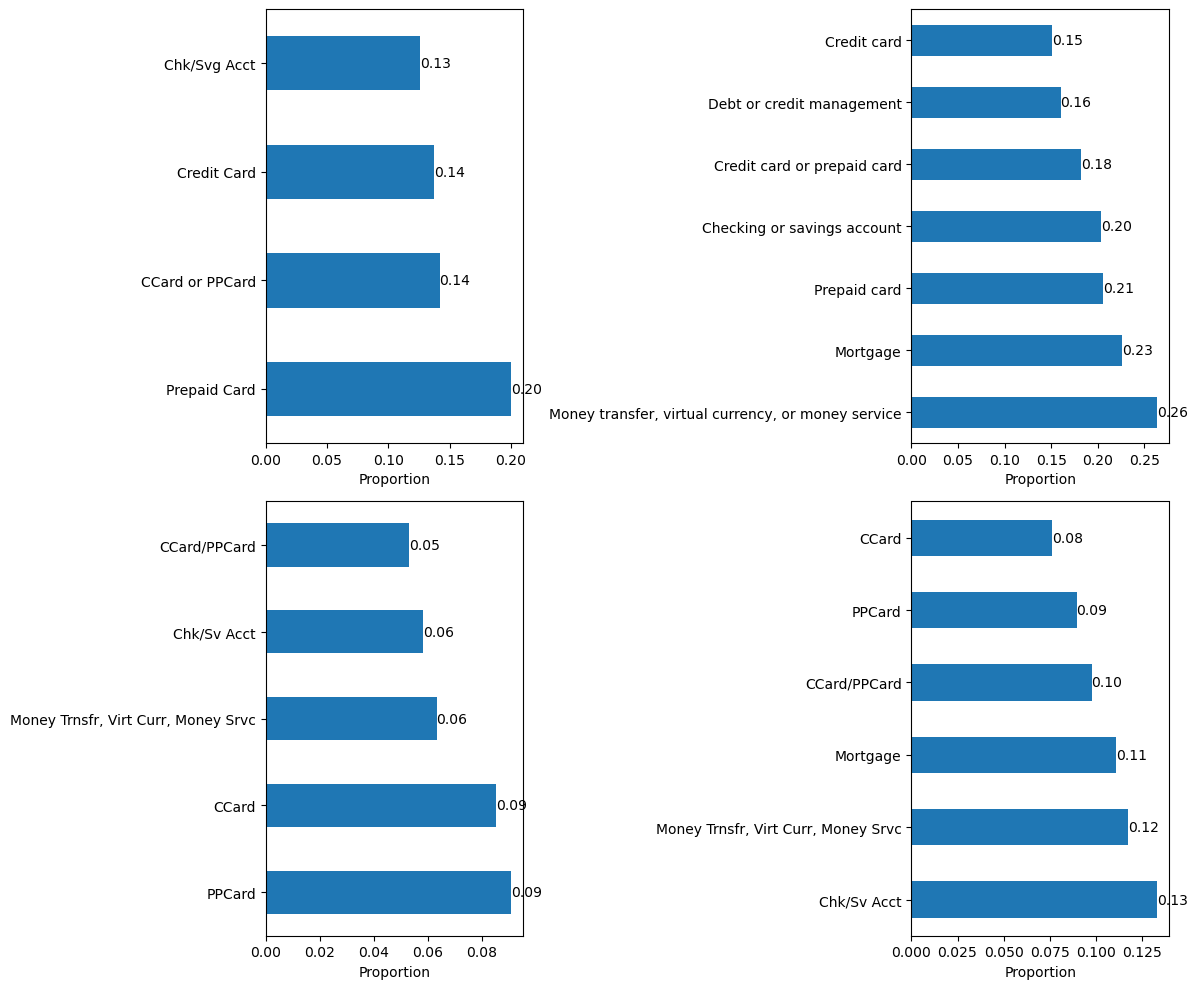

In [114]:
# Create sample DataFrames
cs_df = pd.DataFrame({'Products': ['Prepaid Card', 'CCard or PPCard', 'Credit Card', 'Chk/Svg Acct'],
                      'Proportions': [0.200117, 0.141875, 0.137108, 0.126247]})
help_df = pd.DataFrame({'Products': ['Money transfer, virtual currency, or money service', 'Mortgage', 'Prepaid card',
                                     'Checking or savings account', 'Credit card or prepaid card',
                                     'Debt or credit management', 'Credit card'],
                        'Proportions': [0.263403, 0.226413, 0.205368, 0.203061, 0.181727, 0.160121, 0.150851]})
support_df = pd.DataFrame({'Products': ['PPCard', 'CCard', 'Money Trnsfr, Virt Curr, Money Srvc',
                                        'Chk/Sv Acct', 'CCard/PPCard'],
                           'Proportions': [0.090723, 0.085074, 0.063192, 0.058118, 0.052967]})
wait_df = pd.DataFrame({'Products': ['Chk/Sv Acct', 'Money Trnsfr, Virt Curr, Money Srvc', 'Mortgage',
                                     'CCard/PPCard', 'PPCard', 'CCard'],
                        'Proportions': [0.133128, 0.117428, 0.110874, 0.097695, 0.089557, 0.076301]})
# Put dfs in a list for easier looping
dfs = [cs_df, help_df, support_df, wait_df]
# Create the figure
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
axes = axes.flatten()  # flatten for easy iteration
for ax, df in zip(axes, dfs):
    df.plot.barh(x='Products', y='Proportions', ax=ax, legend=False)
    # Add labels to each bar
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f")  # shows 0.20, 0.14 etc.
    # Improve spacing
    ax.set_xlabel("Proportion")
    ax.set_ylabel("")
    ax.set_title("")
plt.tight_layout()
plt.show()

# --END--